#### This notebook attempts to Fit a VGG16 pretrained model

In [2]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing import image
from joblib import dump
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from sklearn.utils.class_weight import compute_class_weight

    Let's set the primary hardware computational resource to GPU

In [3]:
tf.device = tf.device("gpu")

    Define Constants

In [5]:
BATCH_SIZE = 128
IMG_WIDTH = 224
IMG_HEIGHT = 224
EPOCHS = 40

    Data Directories

In [6]:
train_dir = '../datasets/train'
test_dir = '../datasets/test'

    Perform Data Augmentation for the Data

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

    Preprocess the test data in simple manner.

In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'  
)

Found 4173 images belonging to 2 classes.


    Get validation images in batches using validation generator.

In [10]:
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 1043 images belonging to 2 classes.


    One way to fight imbalance is to have class weights defined and add penalty for misclassfying minority class.
    - Generate samples, find weights and then use that to fit the model.

In [11]:
temp_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',  
    shuffle=False  
)


Found 5216 images belonging to 2 classes.


    Compute the class weights

In [12]:
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(temp_generator.classes),
    y=temp_generator.classes
)

    Convert weights into dictionary

In [13]:
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

    We must also incorporate early_stopping to prevent our layers from over-fitting.

In [19]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # To print messages when the callback takes an action
    restore_best_weights=True  # Optional: Restore model weights from the epoch with the best value of the monitored quantity
)

    Load the VGG16 model

In [14]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 2s 0us/step


    Freeze the layers of the base model:

In [15]:
for layer in base_model.layers:
    layer.trainable = False

    Adding our custom layers:

In [16]:
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

In [17]:
model = Model(inputs=base_model.input, outputs=predictions)

In [18]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    Fit this modified VGG16:

In [20]:
history = model.fit(train_generator, 
                    epochs=EPOCHS, 
                    validation_data=validation_generator, 
                    class_weight=class_weight_dict,
                    callbacks=[early_stopping])


Epoch 1/40
33/33 [==============================] - 368s 11s/step - loss: 1.1972 - accuracy: 0.7764 - val_loss: 0.3589 - val_accuracy: 0.8821
Epoch 2/40
33/33 [==============================] - 374s 11s/step - loss: 0.2686 - accuracy: 0.8967 - val_loss: 0.2619 - val_accuracy: 0.8763
Epoch 3/40
33/33 [==============================] - 375s 11s/step - loss: 0.1889 - accuracy: 0.9216 - val_loss: 0.2486 - val_accuracy: 0.9012
Epoch 4/40
33/33 [==============================] - 373s 11s/step - loss: 0.1845 - accuracy: 0.9255 - val_loss: 0.2400 - val_accuracy: 0.9012
Epoch 5/40
33/33 [==============================] - 375s 11s/step - loss: 0.1657 - accuracy: 0.9348 - val_loss: 0.1471 - val_accuracy: 0.9492
Epoch 6/40
33/33 [==============================] - 378s 11s/step - loss: 0.1596 - accuracy: 0.9329 - val_loss: 0.1481 - val_accuracy: 0.9386
Epoch 7/40
33/33 [==============================] - 388s 12s/step - loss: 0.1692 - accuracy: 0.9341 - val_loss: 0.2289 - val_accuracy: 0.9080
Epoch 

    Training Acc. VS Validation Acc.

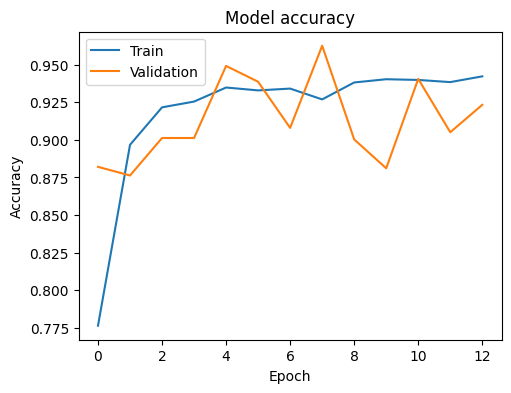

In [21]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

    Training Loss VS Validation Loss

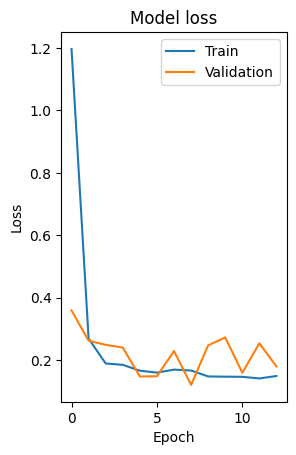

In [22]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

    Generate Test samples:

In [24]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  
)

Found 624 images belonging to 2 classes.


    Make Predictions

In [56]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
predicted_classes = np.where(predictions > 0.70, 1, 0).reshape(-1)
true_classes = test_generator.classes

5/5 [==============================] - 41s 8s/step


In [57]:
report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices)
print(report)

              precision    recall  f1-score   support

      NORMAL       0.90      0.88      0.89       234
   PNEUMONIA       0.93      0.94      0.94       390

    accuracy                           0.92       624
   macro avg       0.91      0.91      0.91       624
weighted avg       0.92      0.92      0.92       624



    Let's plot the confusion matrix for the predicitons made:

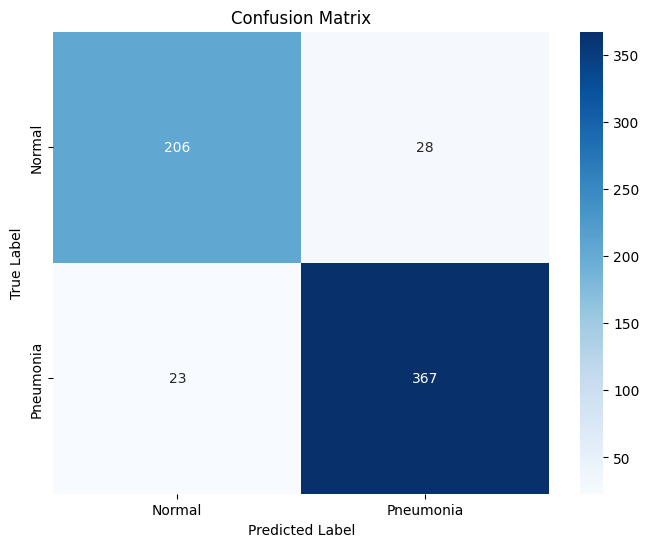

In [58]:
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

    Plot the ROC_curve

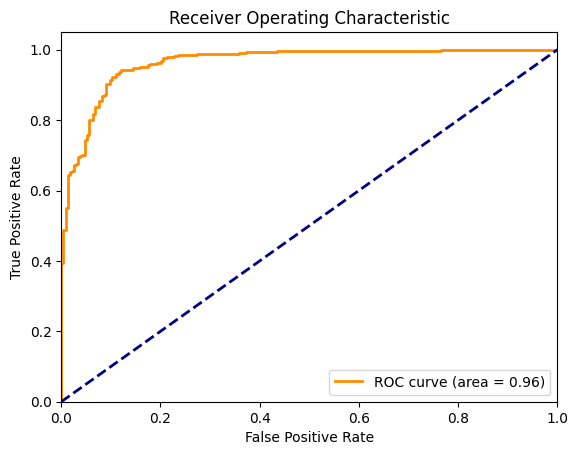

In [59]:
fpr, tpr, _ = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

    Let's save the fitted CNN model for model persistence.

In [61]:
def ask_state():
    if input("Do you want to save this version of model?: yes/no") == "yes":
        dump(model, "../Models/VGG16.joblib")

ask_state()
